In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'mobysound_humpback_whale'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'humpback.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,SNR,indv,indvi,key,audio,rate,spectrogram
0,15.000000,18.020000,20.783400,UNK,0,940305-0921,"[0.0014929071, 0.030802466, 0.035523407, -0.02...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,18.680000,25.760000,29.786501,UNK,0,940305-0921,"[-0.017301673, 0.007829622, -0.020021146, -0.0...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,26.969999,29.389999,33.075901,UNK,0,940305-0921,"[0.016452115, 0.026570419, -0.013069885, -0.01...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [9]:
len(syllable_df)

2310

In [10]:
len(syllable_df)

2310

Text(0.5, 1.0, 'min')

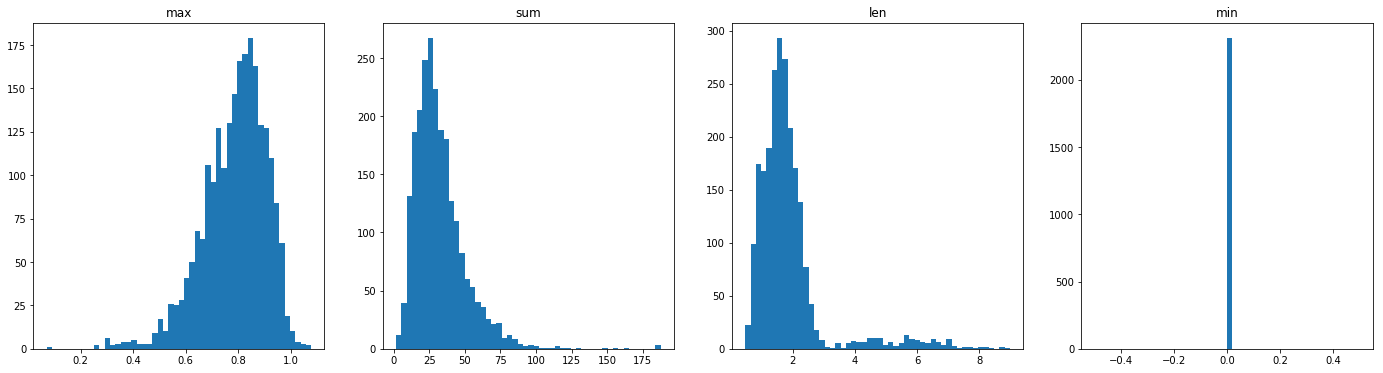

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [12]:
len(syllable_df)

2310

In [13]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2310, 768)

In [ ]:
from cuml.manifold.umap import UMAP as cumlUMAP

cuml_umap = cumlUMAP()
embedding = cuml_umap.fit_transform(specs_flattened)

In [14]:
fit = umap.UMAP(min_dist=0.25)

In [15]:
np.shape(specs_flattened)

(2310, 768)

In [16]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mo

In [17]:
z = np.vstack(z)

### variation across populations

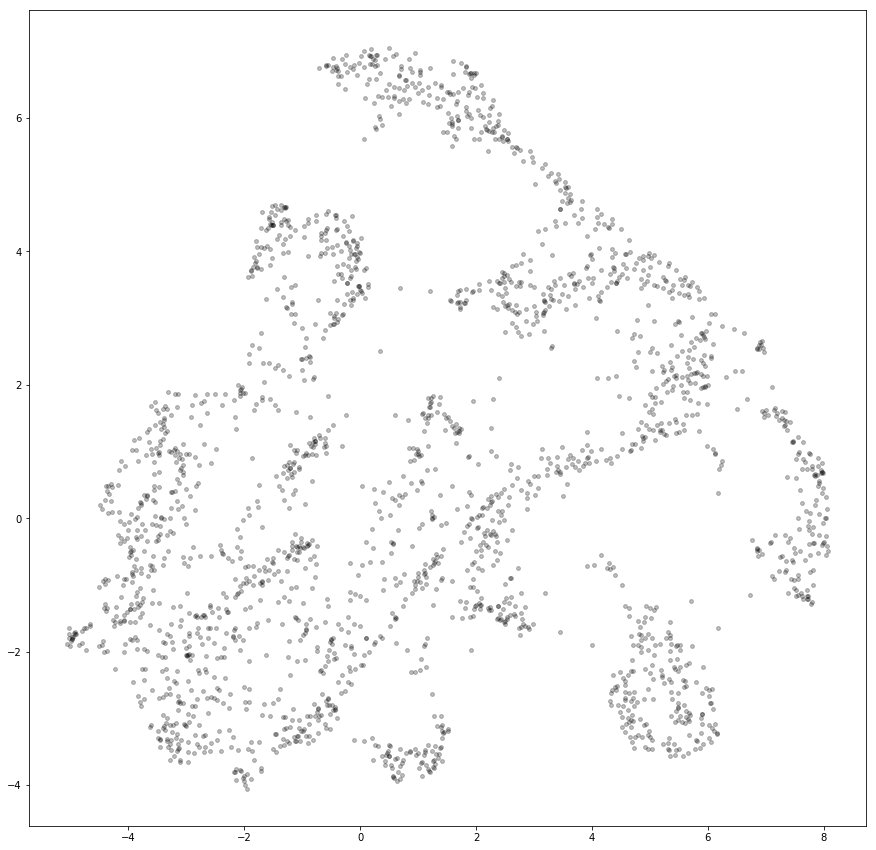

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=0.25, s=15, ax = ax)
plt.show()

In [19]:
syllable_df[:3]

,start_time,end_time,SNR,indv,indvi,key,audio,rate,spectrogram
0,15.000000,18.020000,20.783400,UNK,0,940305-0921,"[0.0014929071, 0.030802466, 0.035523407, -0.02...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,18.680000,25.760000,29.786501,UNK,0,940305-0921,"[-0.017301673, 0.007829622, -0.020021146, -0.0...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,26.969999,29.389999,33.075901,UNK,0,940305-0921,"[0.016452115, 0.026570419, -0.013069885, -0.01...",4000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [20]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

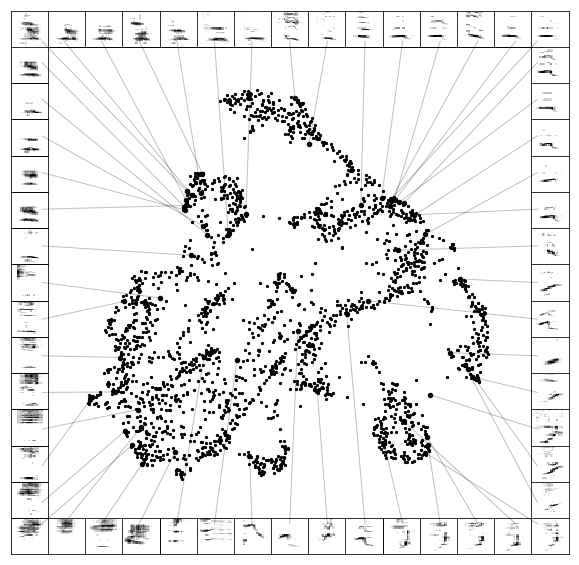

In [22]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        #'labels': subset_df.indv.values,
        'alpha':1,
        's': 5,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
save_fig(FIGURE_DIR / 'humpback_call', dpi=300, save_jpg=True)